In [1]:
%matplotlib notebook
# Continue to examine affect of ip address risk on passing rate.
# First, focus on period before Oct 27 when it was [72-80%]
# Second, show other periods
# Third, find the outliers for each week
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import sys
from scipy.stats.mstats import winsorize
import piso                       # Provide methods for intervals

import dmv_test_input as dti      # Local library to read and prep data 

In [2]:
# Intitalize data and parameters

def read_data():
    # Read and cleanse data from akts log and risk database
    df, risk = dti.dmv_risk_input(case=2, save=False)
    
    # Time in minutes. 
    # elapsed time from start to end of test. Sometimes they are out of order.
    df["elapsed"] = abs(df['TestEndDateTime'] - df['TestStartDateTime']).dt.total_seconds()/60.   
    df["passed"]  = (df.Result=="P")
    
    # Drop negative duration since they must be in error
    # Drop long durations because the chance of error is high
    df = df[ (df.duration>0) & (df.duration<120) & (df.elapsed<120)].reset_index()
       
    return df, risk

df, risk = read_data()

# Drop rows in akts where ip has undefined risk<0. They are probably 10. or 192.. nets
df.drop(df[df.score < 0].index, inplace=True)

CHANGEPT = 14.5                   # The passing rate changes at the changept
RATE = 0.67                       # Passing rate reaches steady value
SBIN, EBIN, INC = (5, 100, 5)     # Define bins for risk score
EPSILON = sys.float_info.epsilon  # Smallest float


Original length of sample data is 179142
2862 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 1183 tests


Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'
Risk.find: Could not find IPv4Address for ip_string='2001'


In [3]:
# Generate bins from (SBIN, EBIN, INC) for find passing rate vs risk

# For lookup (see below) to work all intervals have be closed='right' (,]. To include 0 in the 1st
# bin, a value <0 has to be used. -np.inf is one choice. It may be difficult to plot. Another
# choice is import sys; epsilon=sys.float_info.epsilon. Rounding should let plots work.

# bins = pd.IntervalIndex.from_breaks([-np.inf] + list(np.arange(sbin, ebin+inc, inc)))

# Alternative:
bins = pd.IntervalIndex.from_breaks([-EPSILON] + list(np.arange(INC, EBIN+INC, INC)))
print(f'The risk score is binned using {SBIN, EBIN, INC=}\n\n{bins=}')

# Construct dataframe for the risk score rates. It can be used to perform the lookup.
rf = pd.DataFrame({'threshold':bins.left, 'bin': list(range(0,20))}, index=bins)


The risk score is binned using SBIN, EBIN, INC=(5, 100, 5)

bins=IntervalIndex([(-2.220446049250313e-16, 5.0], (5.0, 10.0], (10.0, 15.0], (15.0, 20.0], (20.0, 25.0] ... (75.0, 80.0], (80.0, 85.0], (85.0, 90.0], (90.0, 95.0], (95.0, 100.0]], dtype='interval[float64, right]')


In [4]:
# Identify the bin for each event. bin # is calulated from inc. Lower bound is 0.
# epsilon is used so lower edge is not included in interval.
# Factor 100 used after tests to make sure same results were obtained.
fbin = lambda x: int((x-100*EPSILON)/INC)
df['bin'] = df.score.apply(fbin)

# Tried piso intervals. It took too long
# df['bin'] = df.score.apply(lambda x: piso.lookup(rf, x).bin[x])


In [5]:
def find_rate(df, rf):
    # Count # pass (sum of pass) and # (as len)
    # for each (bin, passed.value)

    dr = df.groupby('bin').passed.agg([sum, len]).rename(columns={'sum':'p', 'len':'t'})

    # Calculate the passing rate in each bin
    dr['f'] = dr.t - dr.p
    frate = lambda x:  np.nan if x.t <= 0 else x.p/x.t
    dr['rate'] = dr.apply(frate, axis=1)

    # Join the bin intervals by bin
    dr = dr.merge(rf, left_on='bin', right_on='bin', how='inner')

    # Cum
    dr['cumpass'] = dr.p.cumsum()
    dr['cumfail'] = dr.f.cumsum()
    dr['cumcount'] = dr.t.cumsum()
    
    return dr

# Focus on a particular range - Place to fiddle 

# Drop data after 10/26. This marks the rate apex at 80%. From then
# on it dropped to 62%.
#     df = df[ df.TestStartDateTime <= '10/26/2021' ].reset_index()

# Focus on week following change on 10/26/2021
lo = '11/24/2021'
hi = '11/30/2021'
lotest = df.TestStartDateTime >= lo
hitest =  df.TestStartDateTime <= hi
df1 = df[ (lotest) & (hitest)  ].reset_index()

dr = find_rate(df1, rf)


<IPython.core.display.Javascript object>


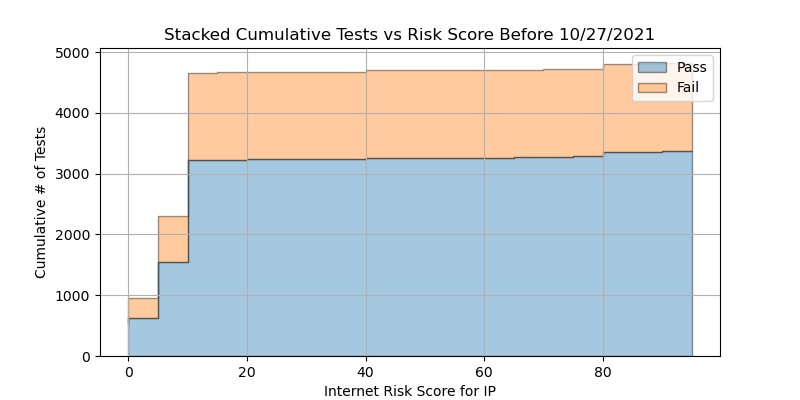

In [6]:
# Plot the cumulative tests as score increases

def plot_cum_vs_risk_score(dr):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.stackplot(dr.threshold, dr.cumpass, dr.cumfail, step='pre', labels=['Pass', 'Fail'], alpha=.4, edgecolor='black')
    ax.set_title(f'Stacked Cumulative Tests vs Risk Score Before 10/27/2021')
    ax.set_xlabel(f'Internet Risk Score for IP')
    ax.set_ylabel(f'Cumulative # of Tests')
    ax.grid(visible=True)
    ax.legend()
    plt.show()

plot_cum_vs_risk_score(dr)    

<IPython.core.display.Javascript object>


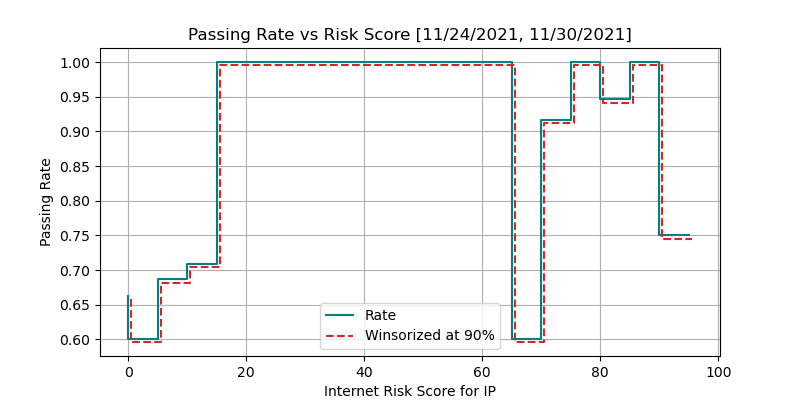

In [7]:

def plot_rate_vs_risk_score(dr, lo, hi):   
    # winsorize
    pct = .1
    dw = winsorize(dr.rate, limits=([pct, pct]))
    
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(dr.threshold, dr.rate, drawstyle='steps', alpha=1, label='Rate', color='teal')
    # Jostle the winsorized line a little to right and below so it shows
    plt.plot(dr.threshold+.5, dw-.005, drawstyle='steps', ls='--', 
             label=f'Winsorized at {1-pct:.0%}', alpha=1, color='tab:red')
    ax.set_title(f'Passing Rate vs Risk Score [{lo}, {hi}]')
    ax.set_xlabel(f'Internet Risk Score for IP')
    ax.set_ylabel(f'Passing Rate')
    ax.legend()
    ax.grid(visible=True)
    plt.show()
    
plot_rate_vs_risk_score(dr, lo, hi)


In [8]:
def find_outliers(df, rate=RATE):
    # Find number of outliers per week. Return dataframe, dr

    df['n'] = True                                                 # use to count # tests
    grouped_by_week = df.resample('W',on='TestStartDateTime')      # Group data by week

    # Sum grouped fields by week
    dr = grouped_by_week.sum().reset_index()

    # Find the rate each week 
    dr['rate'] = dr['passed'] / dr['n']
    dr['failed'] = dr['n'] - dr['passed']

    dr['wkly_adjusted'] = dr.failed*dr.rate/(1-dr.rate)    # This week's num pass excl. outliers
    dr['adjusted'] = dr.failed*rate/(1-rate)               # Same but based on longterm rate
#     dr['outlier'] = dr.passed - dr.adjusted              # Num people who exceed 88% of others
    frate = lambda x: max(0, x.passed-x.adjusted)
    dr['outlier'] = dr.passed - dr.adjusted                # Num people who exceed 88% of others
    dr.outlier = dr.outlier.apply(lambda x: max(0,x))      # Some are < 0 because of fluctuations
    
    # Cum
    dr['cumadjusted'] = dr.adjusted.cumsum()               # Number without outliers
    dr['cumoutlier'] = dr.outlier.cumsum()                 # Num outliers
    dr['cumpassed'] = dr.passed.cumsum()                   # Num who passed
    dr['cumfailed'] = dr.failed.cumsum()                   # Num who failed
    
    return dr


In [9]:
col = ['TestStartDateTime', 'passed', 'failed', 'n', 'rate'
      , 'wkly_adjusted', 'adjusted', 'outlier']

dr = find_outliers(df)
dr[col]


,TestStartDateTime,passed,failed,n,rate,wkly_adjusted,adjusted,outlier
0,2021-10-03,3436,1063,4499,0.763725,3436.0,2158.212121,1277.787879
1,2021-10-10,8821,2840,11661,0.756453,8821.0,5766.060606,3054.939394
2,2021-10-17,8825,2712,11537,0.764930,8825.0,5506.181818,3318.818182
3,2021-10-24,8390,2460,10850,0.773272,8390.0,4994.545455,3395.454545
4,2021-10-31,6103,2286,8389,0.727500,6103.0,4641.272727,1461.727273
5,2021-11-07,5828,2748,8576,0.679571,5828.0,5579.272727,248.727273
6,2021-11-14,5727,2635,8362,0.684884,5727.0,5349.848485,377.151515
7,2021-11-21,4927,2384,7311,0.673916,4927.0,4840.242424,86.757576
8,2021-11-28,3953,1687,5640,0.700887,3953.0,3425.121212,527.878788
9,2021-12-05,4256,2111,6367,0.668447,4256.0,4285.969697,0.000000


<IPython.core.display.Javascript object>


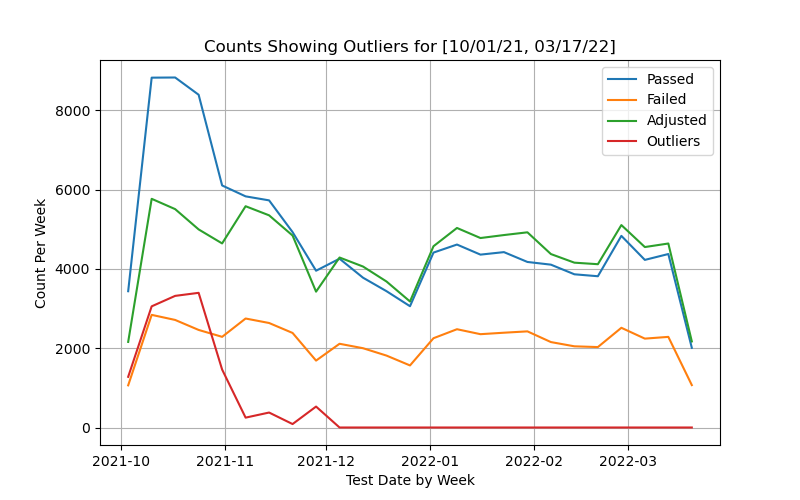

In [10]:
def plot_outliers(dr, lo, hi, fw=6, fh=4):
    fig, ax = plt.subplots(figsize=(fw, fh))
    plt.plot(dr.TestStartDateTime, dr['passed'], label='Passed')
    plt.plot(dr.TestStartDateTime, dr.failed, label='Failed')
    plt.plot(dr.TestStartDateTime, dr.adjusted, label='Adjusted')
    plt.plot(dr.TestStartDateTime, dr.outlier, label='Outliers')
#     import mplcursors
#     mplcursors.cursor(hover=True)
    ax.set_title(f'Counts Showing Outliers for [{lo:%m/%d/%y}, {hi:%m/%d/%y}]')
    ax.set_xlabel(f'Test Date by Week')
    ax.set_ylabel(f'Count Per Week')
    ax.legend()
    ax.grid(visible=True)
    ax.legend()
    plt.show()
    
lo1 = df.TestStartDateTime.min()
hi1 = df.TestStartDateTime.max()

plot_outliers(dr, lo1, hi1, fw=8, fh=5)

<IPython.core.display.Javascript object>


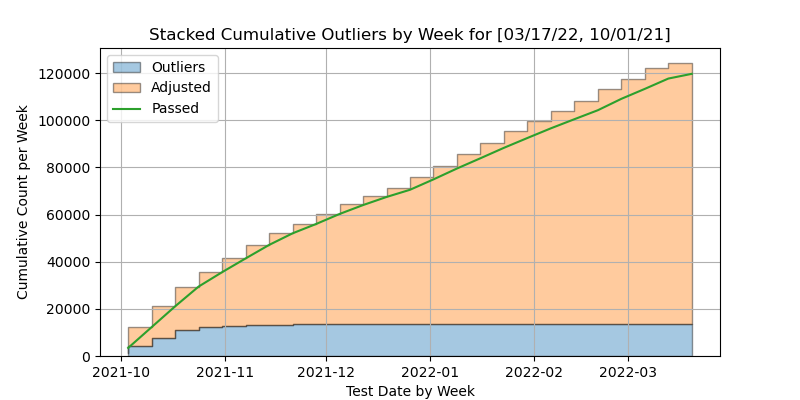

In [11]:
# Plot the cumulative tests as score increases

def plot_outliers_cum(dr, hi, lo):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.stackplot(dr.TestStartDateTime
                  , dr.cumoutlier, dr.cumadjusted
                  , step='pre', alpha=.4, edgecolor='black'
                  , labels=['Outliers', 'Adjusted'])
    plt.plot(dr.TestStartDateTime, dr.cumpassed, label='Passed')
    ax.set_title(f'Stacked Cumulative Outliers by Week for [{lo:%m/%d/%y}, {hi:%m/%d/%y}]')
    ax.set_xlabel(f'Test Date by Week')
    ax.set_ylabel(f'Cumulative Count per Week')
    ax.grid(visible=True)
    ax.legend(loc='upper left')
    plt.show()

plot_outliers_cum(dr, lo1, hi1)  

In [12]:
dr[dr.TestStartDateTime>'11/07/2021'].outlier.describe()

count     19.000000
mean      52.199362
std      144.655810
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      527.878788
Name: outlier, dtype: float64

In [13]:
col=['TestStartDateTime', 'TotalScore', 'duration', 
     'score', 'passed', 'n', 'rate', 'failed', 'adjusted',
       'outlier', 'cumadjusted', 'cumoutlier', 'cumpassed', 'cumfailed']
dr[col]

,TestStartDateTime,TotalScore,duration,score,passed,n,rate,failed,adjusted,outlier,cumadjusted,cumoutlier,cumpassed,cumfailed
0,2021-10-03,190836,123285.766667,59761.0,3436,4499,0.763725,1063,2158.212121,1277.787879,2158.212121,1277.787879,3436,1063
1,2021-10-10,493175,320699.583333,154385.0,8821,11661,0.756453,2840,5766.060606,3054.939394,7924.272727,4332.727273,12257,3903
2,2021-10-17,489282,315412.616667,157244.0,8825,11537,0.764930,2712,5506.181818,3318.818182,13430.454545,7651.545455,21082,6615
3,2021-10-24,460684,296214.066667,144950.0,8390,10850,0.773272,2460,4994.545455,3395.454545,18425.000000,11047.000000,29472,9075
4,2021-10-31,351478,224644.166667,106362.0,6103,8389,0.727500,2286,4641.272727,1461.727273,23066.272727,12508.727273,35575,11361
5,2021-11-07,353900,226754.433333,108612.0,5828,8576,0.679571,2748,5579.272727,248.727273,28645.545455,12757.454545,41403,14109
6,2021-11-14,346543,218966.166667,113718.0,5727,8362,0.684884,2635,5349.848485,377.151515,33995.393939,13134.606061,47130,16744
7,2021-11-21,301663,192826.250000,97632.0,4927,7311,0.673916,2384,4840.242424,86.757576,38835.636364,13221.363636,52057,19128
8,2021-11-28,234333,147818.800000,80672.0,3953,5640,0.700887,1687,3425.121212,527.878788,42260.757576,13749.242424,56010,20815
9,2021-12-05,261876,170880.600000,84790.0,4256,6367,0.668447,2111,4285.969697,0.000000,46546.727273,13749.242424,60266,22926


In [14]:
dr[['n', 'outlier', 'passed', 'failed']].sum()

n          174277.000000
outlier     13749.242424
passed     119740.000000
failed      54537.000000
dtype: float64

In [15]:
def outlier_variation(df, mxscore=20, changept=CHANGEPT):
    # Variation of Outliers by duration, risk and countrycode

    def count_outliers(df, condition):
        df2 = df[ df.passed & condition ].reset_index()
        try:
            dr2 = find_outliers(df2)
            return dr2[['passed', 'outlier']].sum()
        except:
            return -1, -1

    conditions = [df.duration<=changept, df.duration>changept, 
                  df.score >= mxscore, df.score < mxscore, 
                  df.passed == True, df.passed == False, 
                  df.countrycode == "US", df.countrycode != "US",
                  ((df.score >= mxscore) | (df.countrycode!="US"))]

    labels = [f'duration<={changept}', f'duration>{changept}', 
              f'score >= {mxscore}', f'score < {mxscore}', 
              'passed == True', 'passed == False', 
              'in "US"', 'not in US', 'Risk or not US']

    for i, a in enumerate(conditions[0:2]):
        print(f'\n{labels[i]:32}outliers')

        for j, b in enumerate(conditions[2:]):
            print(f'--> {labels[j+2]:25}   ', end='')
            condition = a & b
            passed, outlier = count_outliers(df, condition)
            print(f'{outlier:8.0f}')
    return


for ms in [15]:
    outlier_variation(df, mxscore=ms)



duration<=14.5                  outliers
--> score >= 15                    15027
--> score < 15                     14144
--> passed == True                 29171
--> passed == False                   -1
--> in "US"                        27466
--> not in US                       1705
--> Risk or not US                 15709

duration>14.5                   outliers
--> score >= 15                    47774
--> score < 15                     42795
--> passed == True                 90569
--> passed == False                   -1
--> in "US"                        88151
--> not in US                       2418
--> Risk or not US                 48866
